In [1]:
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [2]:
#Get the stock
ticker = 'SYY'
stock ="Sysco"
# Time step n days, here we will use n  days historical data to predict next day closing
ts_points = 120
# train_data[0:60,0]  

today = datetime.today()
# start_date ='2016-01-01'
start_date = (today - timedelta(days=5*365) ).strftime('%Y-%m-%d')

end_date   = today.strftime('%Y-%m-%d')
stock_df = pdr.DataReader(ticker, data_source="yahoo", start=start_date, end=end_date)

In [3]:
# Date is an index but to be sure , let's sort
stock_df = stock_df.sort_index(ascending=True)
stock_df

High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2016-10-24  48.029999  47.660000  47.669998  47.740002  2484900.0  42.134811
2016-10-25  47.910000  47.310001  47.860001  47.439999  3429000.0  41.870026
2016-10-26  47.500000  47.240002  47.380001  47.259998  2356600.0  41.711166
2016-10-27  47.570000  47.150002  47.310001  47.450001  3789900.0  41.878860
2016-10-28  48.279999  47.430000  47.480000  47.990002  3530800.0  42.355461
...               ...        ...        ...        ...        ...        ...
2021-10-18  82.059998  80.860001  81.389999  81.300003  1474100.0  81.300003
2021-10-19  81.730003  79.489998  81.680000  81.339996  2066400.0  81.339996
2021-10-20  81.580002  79.680000  81.339996  79.820000  2737600.0  79.820000
2021-10-21  80.760002  79.330002  79.900002  79.629997  1567100.0  79.629997
2021-10-22  79.989998  78.639999  79.540001  78.680000  1418400.0  78.680000

[1259 rows x 6 columns]

In [4]:
# check for nulls
stock_df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [5]:
# Get shape
stock_df.shape

(1259, 6)

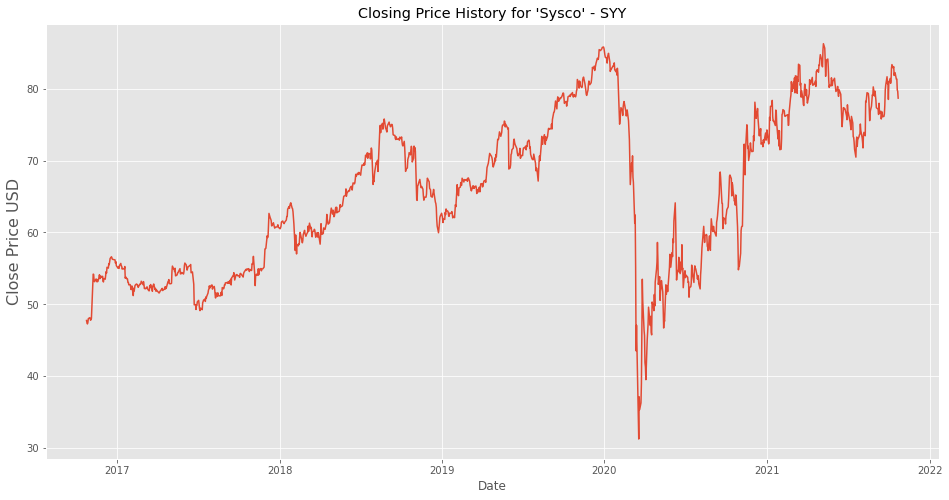

In [6]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(stock_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.show()

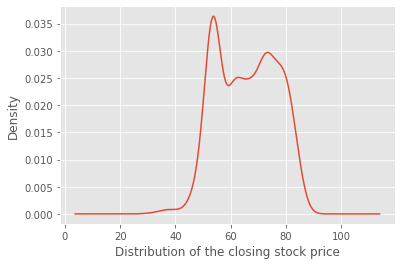

In [7]:
stock_df['Close'].plot.density()
plt.xlabel('Distribution of the closing stock price')
plt.show()

In [8]:
# DF with only close
TSdata_df = stock_df.filter(['Close'])
TSdata_arr = TSdata_df.values # this creates an array of Close Price
TSdata_arr

array([[47.74000168],
       [47.43999863],
       [47.25999832],
       ...,
       [79.81999969],
       [79.62999725],
       [78.68000031]])

In [9]:
# Scale the Data
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(TSdata_arr)
# scaled_data

In [10]:
training_data_len = math.ceil(len(TSdata_arr) * 0.75)
training_data_len

945

In [11]:
# Created scaled training dataset
train_data = scaled_data[0:training_data_len]
train_data.shape

(945, 1)

In [12]:
# Split
X_train = []
y_train = []

for i in range(ts_points, len(train_data)):
    X_train.append(train_data[i-ts_points:i,0])
    y_train.append(train_data[i,0])
    # if i <= ts_points+3:
    #     print(X_train)
    #     print(y_train)
    #     print()


In [13]:
# convert X_train and y_train to numpy arrays for LSTM
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
print (X_train.shape)
print (y_train.shape)

(825, 120)
(825,)


In [15]:
# LSTM network expects a 3D input (No_of_Samples, number of time steps, and number of features) no_of_features = 1 (Close)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(825, 120, 1)

In [16]:
training_data_len - ts_points

825

In [202]:
# hidden_nodes = int(2/3 * (X_train.shape[1] * 1))
# print(f"The number of hidden nodes is {hidden_nodes}.")

In [17]:
# LSTM MOdel
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# model.add(tf.keras.layers.LSTM(50, return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(25))
# model.add(tf.keras.layers.Dense(1))
# model.summary()


In [18]:

# BEST FOR TESLA#
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.summary()

#model.fit(X_train, y_train, batch_size=64, epochs=50

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [20]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size=64

os.makedirs("chk_points/", exist_ok=True)
chkpoint_path="chk_points/weights.{epoch}.hdf5"

# Create chk points
chkpt_callback = ModelCheckpoint(filepath=chkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

# chkpoint_path = "chk_points/cp-{epoch:04d}.ckpt"
# chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=chkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*batch_size)                    

# model.save_weights(chkpoint_path.format(epoch=0))    


In [207]:
# training_data_len
# scaled_data

In [21]:
# model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_split=0.43, callbacks=[chkpt_callback])
model.fit(X_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
13/13 [==============================] - 6s 183ms/step - loss: 0.1069
Epoch 2/50
13/13 [==============================] - 3s 194ms/step - loss: 0.0114
Epoch 3/50
13/13 [==============================] - 2s 167ms/step - loss: 0.0065
Epoch 4/50
13/13 [==============================] - 2s 169ms/step - loss: 0.0052
Epoch 5/50
13/13 [==============================] - 2s 154ms/step - loss: 0.0042
Epoch 6/50
13/13 [==============================] - 2s 146ms/step - loss: 0.0036
Epoch 7/50
13/13 [==============================] - 2s 173ms/step - loss: 0.0033
Epoch 8/50
13/13 [==============================] - 2s 156ms/step - loss: 0.0031
Epoch 9/50
13/13 [==============================] - 2s 153ms/step - loss: 0.0030
Epoch 10/50
13/13 [==============================] - 2s 142ms/step - loss: 0.0029
Epoch 11/50
13/13 [==============================] - 2s 139ms/step - loss: 0.0029
Epoch 12/50
13/13 [==============================] - 2s 157ms/step - loss: 0.0027
Epoch 13/50
13/13 [======

In [22]:
model.save('Saved_Models/Model_'+ticker+'.h5')

In [23]:
# test_data = scaled_data[training_data_len:]

# Bring in the last 'ts_points' (60 values) from training set so when X_test is used to predict , predictions have same shape as Y_test
# The for loop starts with 'ts_points' thatbmeans the resultant array will have 60 less rows
test_data = scaled_data[training_data_len-ts_points:]
# test_data[0:60,0]


In [24]:
X_test = []
y_test = TSdata_arr[training_data_len:]
for i in range(ts_points, len(test_data)):
    X_test.append(test_data[i-ts_points:i,0])


In [25]:
# convert the data to a numpy array to use it in LSTM MODEL
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1], 1))

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
# Models predicted price for X_train
predictions_tr = model.predict(X_train)
predictions_tr = scaler.inverse_transform(predictions_tr)

y_train_tr =  scaler.inverse_transform(y_train.reshape(-1,1))
rmse_tr = math.sqrt(mean_squared_error(y_train_tr, predictions_tr))
rmse_tr

1.9294326189058115

In [28]:
# Models predicted price for X_test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [29]:
y_test.shape, predictions.shape

((314, 1), (314, 1))

In [30]:
# RMSE to check accuracy

rmse = math.sqrt(mean_squared_error(y_test, predictions))
rmse

2.4198834637724542

In [31]:
# Plot
train = TSdata_df[:training_data_len]
actual = TSdata_df[training_data_len:]
actual['Predictions'] = predictions
actual

<ipython-input-31-bb86776ae978>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Predictions'] = predictions


Close  Predictions
Date                              
2020-07-28  53.500000    55.294380
2020-07-29  53.990002    55.111420
2020-07-30  53.590000    54.929848
2020-07-31  52.849998    54.710342
2020-08-03  52.130001    54.397530
...               ...          ...
2021-10-18  81.300003    83.229469
2021-10-19  81.339996    82.839645
2021-10-20  79.820000    82.403786
2021-10-21  79.629997    81.664688
2021-10-22  78.680000    80.854462

[314 rows x 2 columns]

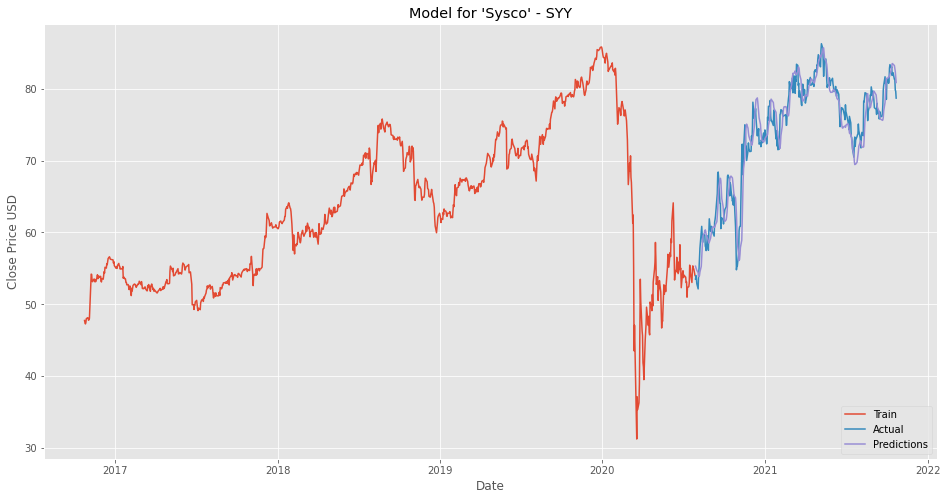

In [32]:
plt.figure(figsize=(16,8))
plt.title(f"Model for '{stock}' - {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price USD")
plt.plot(train['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

# TEST

In [33]:
# for predictions add 100 extra days to make sure it has more than ts_points to make up for missing days (weekends and holidays)

fetch_days = ts_points + 100    

sd =  today - timedelta(days=fetch_days)
sd = sd.strftime('%Y-%m-%d')

ed = today.strftime('%Y-%m-%d')
ed

next_day = (today + timedelta(days=1) ).strftime('%Y-%m-%d')
# next_day

In [34]:
# get the quote
quote = pdr.DataReader(ticker, data_source="yahoo", start=sd, end=ed)
new_df = quote.filter(['Close'])
last_n_days = ts_points
last_n_days_arr = new_df[-last_n_days:].values 

In [35]:
last_n_days_scaled = scaler.transform(last_n_days_arr)
X_test = []
X_test.append(last_n_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))


In [36]:
##########################loading saved model ###############################
new_model = tf.keras.models.load_model('Saved_Models/Model_'+ticker+'.h5')

# Check its architecture
new_model.summary()
nmpred_price = new_model.predict(X_test)
nmpred_price = scaler.inverse_transform(nmpred_price)
nmpred_price = nmpred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {nmpred_price:.4f}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Predicted Closing price for 'Sysco' on 2021-10-24 is 79.9205


In [37]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = pred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {pred_price:.4f}")

Predicted Closing price for 'Sysco' on 2021-10-24 is 79.9205


In [38]:
# verify
d1 = today - timedelta(days=5)
d1 = d1.strftime('%Y-%m-%d')

quote2 = pdr.DataReader(ticker, data_source="yahoo", start=d1)
quote2

High        Low       Open      Close   Volume  Adj Close
Date                                                                      
2021-10-18  82.059998  80.860001  81.389999  81.300003  1474100  81.300003
2021-10-19  81.730003  79.489998  81.680000  81.339996  2066400  81.339996
2021-10-20  81.580002  79.680000  81.339996  79.820000  2737600  79.820000
2021-10-21  80.760002  79.330002  79.900002  79.629997  1567100  79.629997
2021-10-22  79.989998  78.639999  79.540001  78.680000  1418400  78.680000